# Exercise: User Story generation

User stories are brief, simple descriptions of a feature or requirement from the perspective of an end user. They are used in Agile software development to capture the user’s needs and goals in a way that prioritizes functionality and value. A typical user story follows the format:

"As a [type of user], I want [a specific goal] so that [reason or benefit]."

This format ensures the focus stays on delivering solutions that meet the user’s expectations. User stories guide development by defining clear, actionable tasks for teams while remaining flexible and open to adaptation as the project evolves.

Our objective is to create an agent architecture like the following one:

1. **Problem Specification (Domain Specification):**
The process begins with the definition of a problem description, which outlines the domain or context of the system. This serves as the input to the LLM and sets the foundation for generating user stories. Our problem specification is provided as the input to the process.

2. **Role(s) Extraction ("Who" Aspect):**
A prompt is used to extract roles from the problem description.
Roles represent the different types of users or stakeholders involved in the system This step answers "who" the user stories are about.

3. **Function(s) Extraction ("What" Aspect):**
Another prompt is used to extract functions associated with each role.
Functions describe the specific actions or goals the roles aim to perform within the system. This step answers "what" the users want to achieve.

4. **Purpose(s) Extraction ("Why" Aspect):**
A subsequent prompt is used to determine the purposes behind the functions identified. Purposes explain the reasons or motivations behind the desired actions of the roles. This step answers "why" the users need the functions.

5. **User Stories Generation:**
Combining the roles (who), functions (what), and purposes (why), a final prompt generates complete user stories. These user stories take the standard Agile format: "As a \<who\>, I want \<what\>, so that \<why\>."

**Prompt Chain**:
The process is iterative, as each step informs the next and ensures that the roles, functions, and purposes are fully aligned. The LLM is guided by a structured "prompt chain," where prompts are carefully designed to extract specific information at each stage.

**Output**:
The final output consists of user stories that capture the needs and goals of the system's users in a concise, actionable format. These stories guide development teams in implementing the desired features and functionalities.

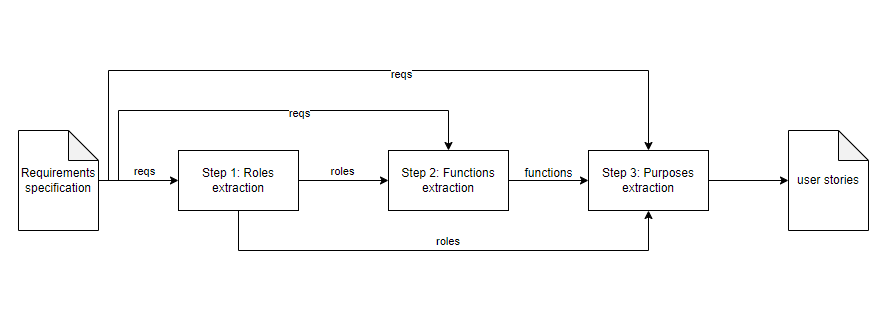

The diagram above shows the overall flow of the LLM architecture.





In [ ]:

#reference requirements_text

requirements_text = "The proposed platform is designed to enhance the hiking experience for various user groups, including visitors, local guides, platform managers, and hut workers. The platform provides a centralized repository of hiking routes, hut information, and parking facilities. It also enables interactive features such as real-time hike tracking, personalized recommendations, and group hike planning. By combining these capabilities, the platform seeks to foster safe, informed, and collaborative hiking experiences.\
The platform will be deployed as a cloud-based web and mobile application accessible to all stakeholders. The distribution strategy includes an app available on major mobile operating systems, such as iOS and Android, alongside a responsive web interface. It will require an internet connection for features like real-time tracking, notifications, and user authentication, though some offline capabilities, such as pre-downloaded hike information, will also be available.\
User authentication will be role-based, ensuring that only authorized users, such as verified hut workers and platform managers, can access sensitive or administrative features.\
Visitors are the primary users of the platform. They can browse a comprehensive list of hiking trails, filter them based on specific criteria such as difficulty, length, or starting point, and view detailed descriptions. To access advanced features like personalized recommendations, visitors can create user accounts by registering on the platform. Registered users can record their fitness parameters, enabling the system to suggest trails tailored to their capabilities.\
During a hike, visitors can record their progress by marking reference points and sharing their live location through a broadcasting URL. They can also initiate group activities by planning hikes, adding group members, and confirming group participation. The platform allows visitors to start, terminate, and track their hikes, with notifications for unfinished hikes or late group members to ensure safety and accountability.\
Local guides enrich the platform by contributing essential information. They can add detailed descriptions of hikes, parking facilities, and huts, ensuring hikers have accurate and comprehensive data. Local guides also link parking lots and huts to specific trails as starting or arrival points, enhancing the planning process.\
To aid in the visual representation and accessibility of information, local guides can upload pictures of huts and connect these locations directly to hikes. This integration simplifies route planning and helps visitors visualize their journey.\
Platform managers oversee the operational integrity and safety of the platform. They verify new hut worker registrations, ensuring that only authorized personnel can update hut-related data. Managers can also broadcast weather alerts for specific areas, notifying all hikers in those regions through push notifications. This ensures that users stay informed about potentially hazardous conditions.\
The platform manager's role includes maintaining an organized and secure user system while facilitating collaboration between local guides, hut workers, and visitors.\
Hut workers are critical to the maintenance of up-to-date trail and accommodation information. After registering and being verified, hut workers can log into the platform to add or update information about their assigned huts, including uploading pictures and describing the facilities available. They can also monitor and report on the condition of nearby trails, ensuring hikers receive current information.\
Hut workers play a vital role in providing situational updates for hikers. For instance, if a nearby trail is impacted by severe weather or physical obstructions, they can communicate these conditions through the platform. This enhances the safety and preparedness of all hikers relying on the platform."


from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
import torch



# Load the tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "meta-llama/Llama-3.2-3B"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id)

print(device)

model = model.to(device)


#we define a method to ask any prompt to llama
def ask_llama(prompt, maxl=200, temp=0.7):
    """
    Send a prompt to the Llama model and get a response.

    Args:
    - prompt (str): The input question or statement to the model.
    - max_length (int): The maximum length of the response.
    - temperature (float): Controls randomness in the model's output.

    Returns:
    - str: The model's generated response.
    """
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")

    inputs.to(device)

    # Generate the output
    outputs = model.generate(
        inputs['input_ids'],  # Tokenized input
        max_length=maxl,         # Limit response length to avoid extra text
        temperature=temp,        # Lower temperature to reduce randomness
        do_sample=True,        # Disable sampling for deterministic output
        pad_token_id=tokenizer.eos_token_id  # Ensure the model doesn't go beyond the end token
    )

    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# Example usage
prompt = """
System: You are an expert on world capitals.
Respond with only the capital city of the given country. Do not repeat the question.

Query: What is the capital of France?
Answer:
"""

response = ask_llama(prompt)

print(f"Prompt: {prompt}\nResponse: {response}")





## Extracting the Actors

To automate the extraction of roles ("Who" aspect) from a problem description, we utilize a language model (LLM) to identify key actors or stakeholders involved in the system. Roles, such as "visitors," "local guides," "platform managers," and "hut workers," represent the primary users or contributors to the system and are essential for generating accurate and actionable user stories. This step focuses on using the LLM to extract these roles and then validating the quality of the extraction by comparing the results against a reference dataset.

The LLM is provided with a detailed problem description and prompted to extract the roles (actors) associated with the system. The prompt is carefully designed to ensure the LLM captures all relevant **roles** based on the context of the problem. The output is a list of roles that the LLM determines as key stakeholders in the system.







In [ ]:
#define three different prompts for extracting users, using the zero-shot, one-shot and few-shot approach. then evaluate the difference in terms of capability to format the output and actual results

context_zero_shot = ""

context_one_shot = ""

context_few_shots = ""

# Concatenate the prompt with the requirements text
prompt_zero_shot = context_zero_shot + requirements_text + '\nAnswer: '
prompt_one_shot = context_one_shot + requirements_text + '\nAnswer: '
prompt_few_shots = context_few_shots + requirements_text + '\nAnswer: '

# Call the LLM function for the three prompts and print the results
roles_extracted_zero_shot = ""

print("Extracted Roles - zero shot: \n", roles_extracted_zero_shot)

roles_extracted_one_shot = ""

print("Extracted Roles - one shot: \n", roles_extracted_one_shot)


roles_extracted_few_shots = ""

print("Extracted Roles - few shots: \n", roles_extracted_few_shots)




While no external dataset is used to refine or influence the role extraction process, we validate the extracted roles against a reference dataset contained in a CSV file named stories.csv. This file includes a specific column listing all the predefined roles associated with the system. These roles serve as the ground truth for validation purposes.


To assess the accuracy and completeness of the LLM’s role extraction, we compute the precision and recall metrics by comparing the LLM's output to the ground truth roles:

- **Precision**: Measures how many of the roles extracted by the LLM are correct (i.e., exist in the reference dataset).

  $P = \frac{True\ Positives}{True\ Positives + False\ Positives}$


- **Recall**: Measures how many of the ground truth roles were successfully identified by the LLM.

  $R = \frac{True\ Positives}{True\ Positives + False\ Negatives}$


After extracting the roles using the LLM, the results are compared to the roles in the reference column from the CSV file. For each role identified by the LLM:

- If the role exists in the reference dataset, it is considered a true positive.
- If the role does not exist in the reference dataset, it is marked as a false positive.
- Any role in the reference dataset that the LLM fails to identify is considered a false negative.

The final output of this process includes:
- A list of roles extracted by the LLM.
- Precision and recall metrics, which provide a quantitative assessment of the LLM’s performance in role extraction.

In [ ]:
import csv
import re

#define a function to extract unique roles from the .csv files with user stories

def extract_unique_roles(file_path):
    roles = set()

    #write here your code

    return list(roles)


# find the unique roles and put them into a list
file_path = 'stories.csv'
expected_roles = extract_unique_roles(file_path)
print(expected_roles)       #EXPECTED RESULT FOR ROLES


#now extract unique roles from the result provided by the LLM
#for simplicity, we only consider the few shots prompt for this purpose

actual_roles = ""

print(actual_roles)         #ACTUAL RESULT FOR ROLES



#write your code here to compute precision and recall
#use normalized roles, i.e., don't consider spaces and 's' at the end of the roles

true_positives = 0
false_positives = 0
false_negatives = 0

precision = 0
recall = 0


# Print results
print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)
print("Precision:", precision)
print("Recall:", recall)




## Extracting the Functions

In this step, the primary goal is to automate the identification of functions required by the roles identified in the previous step (Role Extraction). The function refers to the tasks or actions that the roles need to perform within the system. To achieve this, a language model (LLM) is used to analyze the problem description, and based on the roles identified, it is prompted to extract the functions those roles desire to perform.

For example, after identifying the role of "visitors" or "local guides," the LLM is prompted to determine the specific actions these roles want to carry out within the system, such as "view hikes," "add descriptions," or "manage registrations." This extraction process is critical for understanding the functionality needed in the system to meet the requirements of its stakeholders.

By leveraging the context and the roles passed from the previous step, the LLM extracts a list of desired functions. This list helps define the operational scope of the system and lays the foundation for generating user stories in subsequent steps. The extracted functions are validated to ensure completeness and alignment with the roles' needs.


In [ ]:


current_roles = actual_roles
MAX_FUNCTIONS = 15


#this function will be used to extract the functions from the answer provided by the llm agent

def extract_functions(text):
    functions = list()

    return functions


#this function can be used to format a user story in the expected format. it returns a list of tuples (user, story)

def create_user_stories(role, functions):
    # Generate user stories in the desired format
    user_stories = [(role, f"As a {role}, I want to {function}") for function in functions]
    return user_stories


for role in current_roles:

    #1. Loop over the list of roles and extract the piece of text from requirements related to that role


    #define a prompt to extract functions for a given user
    #the prompt will be composed of the following fields:
    # - context: usage persona of the Lllama agent and instructions
    # - examples: examples of requirements text, role and user
    # - task: description of the task to perform. here you have to provide the current role
    # - answer field: placeholder from which the response will start

    #a tentative example can be the following one (you can generate many of them for instance by using another LLM agent, e.g. ChatGPT)
    example1_text = """
    ### Example 1:
    **Requirements Text**:
    "The application is designed to streamline food delivery operations. Customers can browse menus and place orders. Delivery personnel use the app to view delivery assignments and update order statuses. Restaurant managers can manage their menus and track incoming orders."

    **Functions for Delivery personnel**:
    1. View delivery assignments.
    2. Update order status.
    """

    tmp_prompt= ""


    #now ask the agent and get the response
    response = ""

    print(response)

    functions = extract_functions(response)

    tmp_user_stories = create_user_stories(role, functions)


    #for function in functions:
    #    user_story = f"As a {role} I want to {function}"
    #    user_stories.append(user_story)





## Extracting the purposes

In this step, the focus is on extracting the purposes behind the functions identified in the previous step. The purpose refers to the underlying reasons or motivations that drive a role to perform a particular function within the system. The language model (LLM) is prompted to identify these reasons by analyzing the problem description and the functions extracted in the previous step.

After the functions (what the roles want to do) are identified, the LLM is tasked with understanding and extracting the why behind each function. For example, a role like "hiker" may want to "register for a hike" (function), but the purpose behind this action might be "so that they can track their progress" or "to ensure they can participate in the hike." Similarly, a "local guide" may want to "add a hike description," and the purpose could be "to provide helpful information to other users."

The extracted purposes help provide a deeper understanding of why each function is important to the roles. These purposes are essential for refining the system’s objectives and ensuring that the design aligns with the actual needs and motivations of the stakeholders. The LLM identifies these purposes by analyzing both the context of the roles and the corresponding functions, ensuring that all relevant purposes are captured to provide clarity for the user stories that will follow in the next step.

In [ ]:
#we take the pairs of role - function obtained in the previous step
#for simplicity, we only consider two user stories at this point
#to complete the task, we would require to perform an iteration over all the stories defined - this would be very computationally expensive and is out of the scope of the current exercise

user_story1 = user_stories[0]
user_story2 = user_stories[1]

print(user_story1)

role=user_story1[0]
function=user_story1[1]

print(role)

tmp_prompt = ""